# PROGETTO DWM 2021
### Giovanni Costa - 880892

Indice:
- [Analisi del dataset "Train"](#analisi_train)
- [Analisi del dataset "Properties"](#analisi_prop)
- [Features Engineering](#features_engineer)
    - [Gestione dei missing values e rimozione delle colonne non necessarie o che presentano multicollinearità](#missing_val)
        - [Recupero di missing values per features connesse a posizione geografica e tassazione](#recover_missing_pos_tax)
    - [Aggiunta di features custom potenzialmente utili](#custom_features) 
- [Features importance, features selection e preparazione del dataset finale](#features_selection)
- [Corstruzione del modello sfruttante Random Forest e tuning dei suoi parametri](#mod_1)
- [Corstruzione del modello sfruttante Gradient Boosting e tuning dei suoi parametri](#mod_2)
- [Comparazione e analisi dei modelli](#comparison_and_analisys)
- [Considerazioni finali](#final)

In [1]:
#Import delle librerie
%matplotlib inline
import sys
sys.path.insert(0, '')
import utils as fun #my utils.py file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV 


input_folder='data/'
data_file_name='properties_2016.parquet'
train_file_name='train_2016_v2.csv'

<a id='analisi_train'></a>
### Analisi del dataset "Train"

In [2]:
#Lettura del dataset
df_train=pd.read_csv(input_folder+train_file_name)
df_train.info()
print('Shape: ', df_train.shape)

#Conversione della colonna 'transactiondate' in tipo np.datetime64
df_train['transactiondate']=pd.to_datetime(df_train['transactiondate'], format='%Y-%m-%d')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   parcelid         90275 non-null  int64  
 1   logerror         90275 non-null  float64
 2   transactiondate  90275 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 2.1+ MB
Shape:  (90275, 3)


In [3]:
#Missing values ratio
df_train.isna().sum()/df_train.shape[0] *100

parcelid           0.0
logerror           0.0
transactiondate    0.0
dtype: float64

In [4]:
#Analisi dei duplicati
print(df_train.duplicated(subset='parcelid').sum())
print(df_train.duplicated(subset=['parcelid', 'transactiondate']).sum())

125
0


Notiamo che il dataset contiene 3 colonne:
- Parcelid: id univoco che identifica ogni istanza di edificio
- Logerror: indice che dovremmo utilizzare per verificare la bontà del nostro modello<br>
Dal sito internet della competizione: *"Zillow is asking you to predict the log-error between their Zestimate and the actual sale price, given all the features of a home. The log error is defined as logerror=log(Zestimate)−log(SalePrice)"*
- Transactiondate: data di vendita reale o stimata per quell'istanza di edificio

Inoltre non ci sono valori nulli nel dataset ma ci sono parcelid duplicati, anche se la coppia parcelid e transactiondate è univoca per ogni riga. Questo implica che ci sono dati di vendite reali (o previste) con riferimento allo stesso edificio in diverse giornate

<a id='analisi_prop'></a>
### Analisi del dataset "Properties"

In [5]:
#Lettura del dataset
df_prop=pd.read_parquet(input_folder+data_file_name)
#df_prop=pd.read_csv(input_folder+data_file_name, header=0) #parametro nrows=x per limitare il numero di righe

#Conversione delle colonne da float64 a float32 per diminuire la memoria occupata (circa 600mb in meno)
df_prop[df_prop.select_dtypes(np.float64).columns] = df_prop.select_dtypes(np.float64).astype(np.float32)

df_prop.info()
print('Shape: ', df_prop.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   parcelid                      int64  
 1   airconditioningtypeid         float32
 2   architecturalstyletypeid      float32
 3   basementsqft                  float32
 4   bathroomcnt                   float32
 5   bedroomcnt                    float32
 6   buildingclasstypeid           float32
 7   buildingqualitytypeid         float32
 8   calculatedbathnbr             float32
 9   decktypeid                    float32
 10  finishedfloor1squarefeet      float32
 11  calculatedfinishedsquarefeet  float32
 12  finishedsquarefeet12          float32
 13  finishedsquarefeet13          float32
 14  finishedsquarefeet15          float32
 15  finishedsquarefeet50          float32
 16  finishedsquarefeet6           float32
 17  fips                          float32
 18  fireplacecnt          

In [6]:
#Analisi dei duplicati
print(df_prop.duplicated(subset='parcelid').sum())
print(df_prop.duplicated().sum())

0
0


In [7]:
#Missing values ratio
df_prop.isna().sum().sort_values(ascending=False)/df_prop.shape[0]*100

storytypeid                     99.945599
basementsqft                    99.945465
yardbuildingsqft26              99.911330
fireplaceflag                   99.827048
architecturalstyletypeid        99.796966
typeconstructiontypeid          99.773986
finishedsquarefeet13            99.743000
buildingclasstypeid             99.576949
decktypeid                      99.427311
finishedsquarefeet6             99.263002
poolsizesum                     99.063385
pooltypeid2                     98.925539
pooltypeid10                    98.762603
taxdelinquencyflag              98.108613
taxdelinquencyyear              98.108546
hashottuborspa                  97.688141
yardbuildingsqft17              97.308236
finishedsquarefeet15            93.608572
finishedsquarefeet50            93.209304
finishedfloor1squarefeet        93.209304
threequarterbathnbr             89.560859
fireplacecnt                    89.527160
pooltypeid7                     83.737899
poolcnt                         82

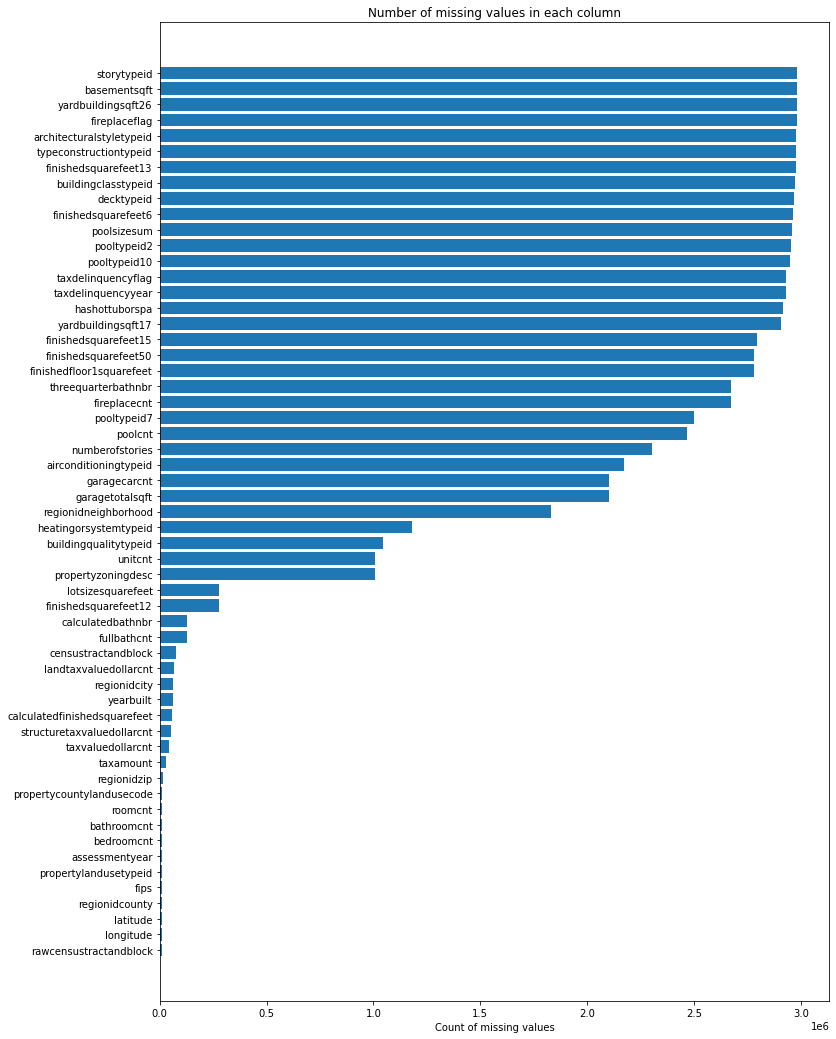

In [8]:
#Missing values graph
df_missing = df_prop.isnull().sum(axis=0).reset_index()
df_missing.columns = ['column_name', 'missing_count']
df_missing = df_missing.loc[df_missing['missing_count']>0]
df_missing = df_missing.sort_values(by='missing_count')

ind = np.arange(df_missing.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, df_missing.missing_count.values)
ax.set_yticks(ind)
ax.set_yticklabels(df_missing.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [9]:
#Selezione delle colonne contenti variabili categoriali sulla base della ducumentazione fornita su kaggle.com (usate successivamente)
other_cols = ['parcelid', 'airconditioningtypeid','architecturalstyletypeid','buildingqualitytypeid','buildingclasstypeid','decktypeid','fips', 'fireplaceflag', 'hashottuborspa', 'heatingorsystemtypeid', 'pooltypeid10','pooltypeid2','pooltypeid7','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock', 'censustractandblock', 'regionidcounty', 'regionidcity', 'regionidzip', 'regionidneighborhood','regionidzip','storytypeid','typeconstructiontypeid', 'assessmentyear', 'taxdelinquencyflag', 'taxdelinquencyyear', 'yearbuilt']
numerical_cols = [x for x in df_prop.columns if x not in other_cols]

In [10]:
#Visualizzazione dei valori delle colonne di tipo non float, int o datetime
not_float_col=df_prop.select_dtypes(exclude=[np.float32, np.int64]).columns
for c in not_float_col:
    print("Column: "+c)
    print("values: ", df_prop[c].unique(), "\n")

Column: hashottuborspa
values:  [None True] 

Column: propertycountylandusecode
values:  ['010D' '0109' '1200' '1210' '010V' '300V' '0100' '0200' '010C' '0300'
 '1204' '100V' '01HC' '120C' '040V' '1214' '0101' None '070P' '0700' '1'
 '128' '0' '1112' '5050' '1110' '1118' '010E' '1111' '1129' '1420' '1222'
 '1128' '1310' '1117' '1333' '1116' '1410' '0104' '070D' '0108' '012C'
 '0400' '0103' '01DC' '0201' '010M' '030V' '0110' '010F' '010G' '010H'
 '0301' '0102' '020E' '020M' '0401' '0113' '0141' '122' '38' '135' '96'
 '71' '73' '34' '0209' '040G' '010L' '012E' '0111' '1720' '1014' '012D'
 '1213' '1201' '1321' '1444' '1421' '0140' '0123' '0133' '020G' '030G'
 '105' '0204' '010T' '0120' '1202' '121G' '010X' '020V' '880V' '1120'
 '0130' '0118' '01HE' '120G' '5060' '0131' '0203' '011C' '1215' '1212'
 '040D' '120T' '0420' '8' '1203' '070X' '0114' '030E' '121T' '1012' '121C'
 '0105' '5' '020C' '0106' '040B' '10E' '1216' '3' '0121' '1722' '1432'
 '1119' '9000' '103' '6050' '8800' '0304' '0303' 

Il dataset presenta molte features e istanze:
- alcune di queste aventi tipo float32 sono in realtà identificativi numerici di tipo intero associati a categorie descritte più approfonditamente nella documentazione di Kaggle.com
- quelle di tipo object invece sono stringhe rappresentanti valori booleani oppure codici relativi a categorie

Le varie colonne verranno quindi gestite successivamente per rappresentare la corretta semantica del dato.

Il dataset inoltre non presenta duplicati né in parcelid né globalmente, ma contiene un numero molto elevato di valori mancanti: diverse colonne infatti presentano un missing ratio superiore al 97%. Nei capitoli successivi verrà illustrato come vengono gestiti tali valori mancanti per ognuna delle features presenti

Per questo particolare task di supervised learning sono sufficienti solamente le abitazioni all'interno del file "train_2016_v2" e non tutte quelle presenti in "properties_2016", si procede quindi all'unione dei due dataset analizzati precedentemente in modo da averne uno unico contenente l'insieme di tutte le colonne e solamente le righe che verranno effettivamente utilizzate per la previsione

In [11]:
df_prop=df_train.merge(df_prop, on='parcelid')
df_prop['transactiondate']=pd.to_datetime(df_prop['transactiondate'], format='%Y-%m-%d')
df_prop[df_prop.select_dtypes(np.float64).columns] = df_prop.select_dtypes(np.float64).astype(np.float32)

Dataset dopo il merge:

In [12]:
df_prop.info()
print('Shape: ', df_prop.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   parcelid                      90275 non-null  int64         
 1   logerror                      90275 non-null  float32       
 2   transactiondate               90275 non-null  datetime64[ns]
 3   airconditioningtypeid         28781 non-null  float32       
 4   architecturalstyletypeid      261 non-null    float32       
 5   basementsqft                  43 non-null     float32       
 6   bathroomcnt                   90275 non-null  float32       
 7   bedroomcnt                    90275 non-null  float32       
 8   buildingclasstypeid           16 non-null     float32       
 9   buildingqualitytypeid         57364 non-null  float32       
 10  calculatedbathnbr             89093 non-null  float32       
 11  decktypeid                  

<a id='features_engineer'></a>
## Features Engineering

<a id='missing_val'></a>
### Gestione dei missing values e rimozione delle colonne non necessarie o che presentano multicollinearità

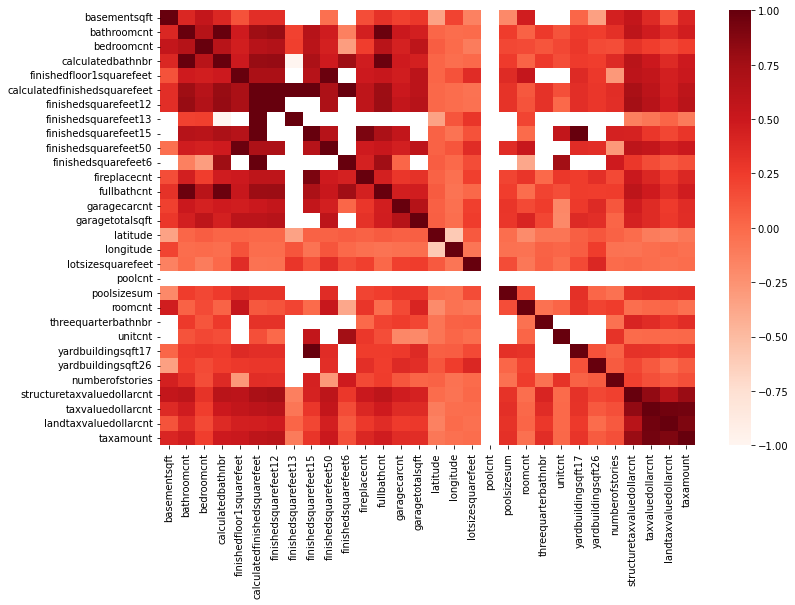

<Figure size 432x288 with 0 Axes>

In [13]:
#Heatmap per visualizzare le correlazioni tra le variabili
plt.figure(figsize = (12,8))
sns.heatmap(data=df_prop[numerical_cols].corr(), cmap='Reds')
plt.show()
plt.gcf().clear()

Dall'analisi della heatmap sulla correlazione tra le variabili numeriche si nota che le features 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15' e 'finishedsquarefeet6' sono molto correlate essendo di colore rosso scuro.
La stessa considerazione si applica anche a 'finishedfloor1squarefeet' e 'finishedsquarefeet50' che in aggiunta nella documentazione fornita hanno la stessa descrizione.
Similmente anche 'bathroomcnt', 'calculatedbathnbr' e 'fullbathcnt' sono correlate

Viene mantenuta solamente 'calculatedfinishedsquarefeet' tra le quattro perché presenta meno valori missing, mentre tra 'finishedfloor1squarefeet' e 'finishedsquarefeet50' viene rimossa arbitrariamente 'finishedsquarefeet50' in quanto il missing ratio è equivalente.

Vengono eliminati anche 'bathroomcnt' e 'calculatedbathnbr' lasciando 'bathroomcnt', in quanto viene applicata un'intuizione analoga alla precedente

In [14]:
df_prop[['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet6']].isna().sum()/df_prop.shape[0] *100

calculatedfinishedsquarefeet     0.732207
finishedsquarefeet12             5.183052
finishedsquarefeet13            99.963445
finishedsquarefeet15            96.052063
finishedsquarefeet6             99.533647
dtype: float64

In [15]:
df_prop.drop(columns=['finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet6'], inplace=True)

In [16]:
df_prop[['finishedfloor1squarefeet', 'finishedsquarefeet50']].isna().sum()/df_prop.shape[0] *100

finishedfloor1squarefeet    92.405428
finishedsquarefeet50        92.405428
dtype: float64

In [17]:
df_prop.drop(columns='finishedsquarefeet50', inplace=True)

In [18]:
df_prop[['calculatedbathnbr', 'bathroomcnt', 'fullbathcnt']].isna().sum()/df_prop.shape[0] *100

calculatedbathnbr    1.309333
bathroomcnt          0.000000
fullbathcnt          1.309333
dtype: float64

In [19]:
df_prop.drop(columns=['calculatedbathnbr', 'fullbathcnt'], inplace=True)

'hashottuborspa' e 'pooltypeid10' presentano semanticamente la stessa descrizione. Si decide di rimuovere 'pooltypeid10' che presenta meno valori missing.

Viene inoltre assunto che se il valore di pool/hot tub (features 'pooltypeid2', 'pooltypeid7', 'poolcnt') non è presente questo indichi 0 elementi presenti nell'edificio

In [20]:
print(df_prop['hashottuborspa'].value_counts())
print(df_prop['pooltypeid10'].value_counts())

True    2365
Name: hashottuborspa, dtype: int64
1.0    1161
Name: pooltypeid10, dtype: int64


In [21]:
df_prop[['hashottuborspa', 'pooltypeid10']].isnull().sum()/df_prop.shape[0] *100

hashottuborspa    97.380227
pooltypeid10      98.713930
dtype: float64

In [22]:
df_prop.drop(columns='pooltypeid10', inplace=True)

In [23]:
df_prop[['pooltypeid2', 'pooltypeid7', 'poolcnt']]=df_prop[['pooltypeid2', 'pooltypeid7', 'poolcnt']].fillna(0)
df_prop['hashottuborspa'].fillna(0, inplace=True) #>90% nan
df_prop['hashottuborspa']=df_prop['hashottuborspa'].astype(bool);

Per quanto riguarda la features 'poolsizesum' viene utilizzata la mediana dei valori presenti alle righe in cui la colonna 'poolcnt' è meggiore di 0, altrimenti questo valore viene impostato a 0
(si sceglie di usare la mediana come filler perchè meno influenzata dagli outliers e perchè si assume che le dimensioni delle piscine negli Stati Uniti siano più o meno standard) 

In [24]:
median_poolsize=df_prop[df_prop['poolcnt']>0]['poolsizesum'].median()
df_prop.loc[(df_prop['poolcnt']>0) & (df_prop['poolsizesum'].isna()), 'poolsizesum']=median_poolsize

#Se non ha la piscina la dimensione della piscina è 0
df_prop.loc[(df_prop['poolcnt'] == 0), 'poolsizesum'] = 0

'fireplaceflag' e 'fireplacecnt' presentano delle inconsistenze:
come si nota dall'analisi sottostante ci sono righe dove 'fireplacecnt' è presente, mentre 'fireplaceflag' è missing oppure errato. 

Si prosegue dunque mettendo a 0 i valori di 'fireplacecnt' quando NaN e impostando a True 'fireplaceflag' quando 'fireplacecnt' è presente, False altrimenti

In [25]:
df_prop['fireplaceflag'].fillna(0, inplace=True) #>90% nan
df_prop['fireplaceflag']=df_prop['fireplaceflag'].astype(bool)
df_prop.loc[(~df_prop['fireplacecnt'].isna()), 'fireplaceflag']=True
df_prop['fireplacecnt'].fillna(0, inplace=True)

Vengono riempiti i valori di 'taxdelinquencyflag', 'garagecarcnt', 'garagetotalsqft' assumendo 0 se il valore è NaN, come fatto in precedenza

In [26]:
df_prop[['taxdelinquencyflag', 'garagecarcnt', 'garagetotalsqft']]=df_prop[['taxdelinquencyflag', 'garagecarcnt', 'garagetotalsqft']].fillna(0)
df_prop['taxdelinquencyflag']=df_prop['taxdelinquencyflag'].astype(bool)

Le features come 'airconditioningtypeid', 'heatingorsystemtypeid',  'threequarterbathnbr' invece si ritengono poco importanti e variabili così si decide di rimpiazzare i valori missing di tali features categoriali con la loro rispettiva moda.<br>
Come si nota dai grafici sottastanti la frequenza di queste variabili categoriali è intuitivamente corretta, ragionevolmente si ipotizza infatti che AC e Heating System siano più comunemente 'Central' e che la maggior parte delle abitazioni abbiano solamente un bagno a trequarti

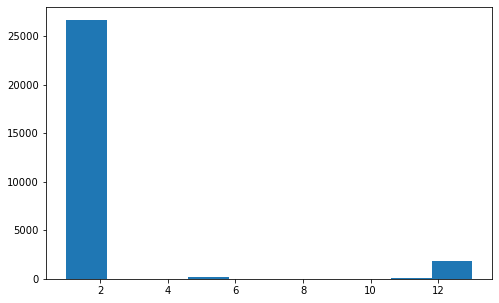

Moda:  1.0


In [27]:
plt.figure(figsize = (8,5))
df_prop['airconditioningtypeid'].astype(int, errors='ignore').hist(grid=False)
plt.show()

mode=float(df_prop['airconditioningtypeid'].mode())
print("Moda: ", mode)
df_prop['airconditioningtypeid'].fillna(mode, inplace=True)

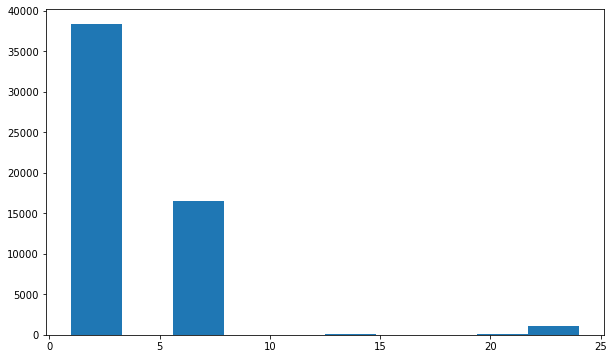

Moda:  2.0


In [28]:
plt.figure(figsize = (10,6))
df_prop['heatingorsystemtypeid'].astype(int, errors='ignore').hist(grid=False)
plt.show()

mode=float(df_prop['heatingorsystemtypeid'].mode())
print("Moda: ", mode)
df_prop['heatingorsystemtypeid'].fillna(mode, inplace=True)

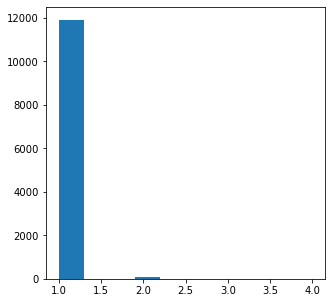

Moda:  1.0


In [29]:
plt.figure(figsize = (5,5))
df_prop['threequarterbathnbr'].astype(int, errors='ignore').hist(grid=False)
plt.show()

mode=float(df_prop['threequarterbathnbr'].mode())
print("Moda: ", mode)
df_prop['threequarterbathnbr'].fillna(mode, inplace=True)

Si decide infine ora di rimuovere le features con missing ratio maggiore di 97% perché ritenute con troppa poca informazione per essere utili al task di regressione

In [30]:
tmp_col=df_prop.columns
for c in tmp_col:
    if df_prop[c].isna().sum()/df_prop.shape[0]>0.97:
        df_prop.drop(columns=c, inplace=True)

In [31]:
tmp_col=df_prop.columns
tmp_list=[]

for c in tmp_col:
    if df_prop[c].isna().sum()/df_prop.shape[0]>0.0:
        tmp_list.append(c)

print("Number of features with missing values: ", len(tmp_list))
print(tmp_list)
print("Number of total features after droping: ", len(df_prop.columns))

Number of features with missing values:  17
['buildingqualitytypeid', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'propertycountylandusecode', 'propertyzoningdesc', 'regionidcity', 'regionidneighborhood', 'regionidzip', 'unitcnt', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock']
Number of total features after droping:  43


Si analizzano quindi le features rimanenti rimanenti cercando di ripristinare gli ultimi missing values

<a id='recover_missing_pos_tax'></a>
### Recupero di missing values per features connesse a posizione geografica e tassazione


In [32]:
geo_col_names=['latitude', 'longitude', 'buildingqualitytypeid', 'propertycountylandusecode', 'propertyzoningdesc', 'regionidcity', 'regionidneighborhood', 'regionidzip', 'unitcnt', 'yearbuilt']
df_geo=pd.DataFrame(df_prop[geo_col_names], columns=geo_col_names)
df_geo.isna().sum()/df_geo.shape[0] *100

latitude                      0.000000
longitude                     0.000000
buildingqualitytypeid        36.456383
propertycountylandusecode     0.001108
propertyzoningdesc           35.405151
regionidcity                  1.997231
regionidneighborhood         60.108557
regionidzip                   0.038770
unitcnt                      35.360842
yearbuilt                     0.837441
dtype: float64

Intuitivamente, vista inoltre l'assenza di valori mancanti, si potrebbero utilizzare le features 'latitude' e 'longitude' relativi alla posizione dell'edificio per recuperare altri attributi non presenti: abitazioni geograficamente vicine infatti si pensa che possano avere determinate caratteristiche simili<br><br>
Si ripristinano quindi i valori originali di queste due features perché come descritto nella documentazine fornita quelli all'interno del dataset sono moltiplicati per 10^6.<br>

In [33]:
df_prop['latitude']=df_prop['latitude']/(10**6)
df_prop['longitude']=df_prop['longitude']/(10**6)
#df_prop.dropna( axis = 0, subset = ['latitude', 'longitude'], inplace = True )

Si è deciso di utilizzare l'algoritmo K-nearest neighbors (KNN) per svolgere il task di recupero perché ritenuto il più adatto visto che si basa sull'apprendimento mediante analogie tra istanze vicine e vista la sua efficienza computazionale. Nella cella di codice sottostante sono inoltre spiegate le motivazioni e le ipotesi usate per il ripristino delle variabili categoriali e numeriche

In [34]:
warnings.simplefilter(action='ignore', category=UserWarning)
parameters = { 'n_neighbors': [1, 2, 3, 4, 5, 8, 10]}


#Si ipotizza che blocchi di case vicine siano state costruite più o meno tutte nello stesso periodo e che quindi abbiano qualità simile
fun.fillna_knn(df=df_prop, base=['latitude', 'longitude'],
           target='buildingqualitytypeid', tuning_params=parameters)

#Abitazioni vicine hanno lo stesso countrylandusecode  
tmp_label_enc=fun.zoningcode2int(df=df_prop, target='propertycountylandusecode')          
fun.fillna_knn(df=df_prop,
           base=['latitude', 'longitude'],
           target='propertycountylandusecode', tuning_params=parameters)
df_prop['propertycountylandusecode']=tmp_label_enc.inverse_transform(df_prop['propertycountylandusecode'].astype(int))


#Abitazioni vicine hanno la stessa zoning description
tmp_label_enc=fun.zoningcode2int(df=df_prop, target='propertyzoningdesc')
fun.fillna_knn(df=df_prop,
           base=['latitude', 'longitude'],
           target='propertyzoningdesc', tuning_params=parameters)
df_prop['propertyzoningdesc']=tmp_label_enc.inverse_transform(df_prop['propertyzoningdesc'].astype(int))


#Anche in questo caso proprietà vicine si assume abbiano gli stessi regionidcity, regionidneighborhood e regionidzip
fun.fillna_knn(df=df_prop,
           base=['latitude', 'longitude'],
           target='regionidcity', tuning_params=parameters)

fun.fillna_knn(df=df_prop,
           base=['latitude', 'longitude'],
           target='regionidneighborhood', tuning_params=parameters)

fun.fillna_knn(df=df_prop,
           base=['latitude', 'longitude'],
           target='regionidzip', tuning_params=parameters)


#Stessa intuizione per i campi 'unitcnt' (Number of units the structure is built into), 'yearbuilt' e 'lotsizesquarefeet'
fun.fillna_knn(df=df_prop,
           base=['latitude', 'longitude'],
           target='unitcnt', tuning_params=parameters)

fun.fillna_knn(df=df_prop,
           base=['latitude', 'longitude'],
           target='yearbuilt', tuning_params=parameters)

fun.fillna_knn_reg(df=df_prop,
           base=['latitude', 'longitude'],
           target='lotsizesquarefeet', tuning_params=parameters)

warnings.simplefilter(action='default', category=UserWarning)

Target:  buildingqualitytypeid
Best Score: 0.785
Best Params:  {'n_neighbors': 1}
Test Accuracy: 0.803
Done!

Target:  propertycountylandusecode
Dealing with variables that are actually string/categories...
num of categories:  (78,)
Target:  propertycountylandusecode
Best Score: 0.770
Best Params:  {'n_neighbors': 2}
Test Accuracy: 0.781
Done!

Target:  propertyzoningdesc
Dealing with variables that are actually string/categories...
num of categories:  (1997,)
Target:  propertyzoningdesc
Best Score: 0.763
Best Params:  {'n_neighbors': 1}
Test Accuracy: 0.780
Done!

Target:  regionidcity
Best Score: 0.984
Best Params:  {'n_neighbors': 1}
Test Accuracy: 0.987
Done!

Target:  regionidneighborhood
Best Score: 0.970
Best Params:  {'n_neighbors': 1}
Test Accuracy: 0.973
Done!

Target:  regionidzip
Best Score: 0.976
Best Params:  {'n_neighbors': 1}
Test Accuracy: 0.979
Done!

Target:  unitcnt
Best Score: 0.937
Best Params:  {'n_neighbors': 10}
Test Accuracy: 0.936
Done!

Target:  yearbuilt
Be

Per quanto riguarda la feature 'finishedfloor1squarefeet', come si può anche notare dalla heatmap all'inizio della sezione corrente, questa è correlata con 'calculatedfinishedsquarefeet'. Si prova quindi ad utilizzare quest'ultima per svolgerne il filling dei valori

<Figure size 936x936 with 0 Axes>

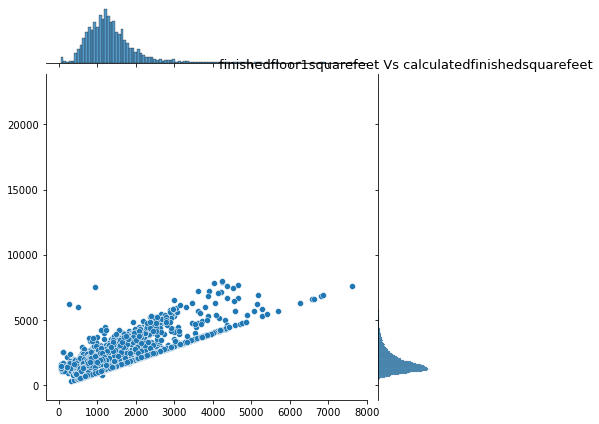

In [35]:
plt.figure(figsize=(13,13))
sns.jointplot(x=df_prop['finishedfloor1squarefeet'].values, y=df_prop['calculatedfinishedsquarefeet'].values)
plt.ylabel('calculatedfinishedsquarefeet', fontsize=10)
plt.xlabel('finishedfloor1squarefeet', fontsize=10)
plt.title("finishedfloor1squarefeet Vs calculatedfinishedsquarefeet", fontsize=13)
plt.show()

Dal grafico si nota che in alcune abitazioni i valori delle features sono esattamente gli stessi: probabilmente alcune case hanno la loro area complessiva occupata da solamente una stanza (come potrebbe essere una sorta di studio). Vengono quindi assunte queste informazioni per vere e si procede al riempimento.<br>
Inoltre alcune righe del dataset contengono valori di 'finishedfloor1squarefeet' maggiori della dimensione totale dell'abitazione, probabilmente dovuto ad un inserimento del dato in input errato. Si decide quindi di rimuovere tali righe dal dataset

In [36]:
df_prop.loc[(df_prop['finishedfloor1squarefeet'].isna()) & (df_prop['numberofstories']==1),'finishedfloor1squarefeet'] = df_prop.loc[(df_prop['finishedfloor1squarefeet'].isna()) & (df_prop['numberofstories']==1),'calculatedfinishedsquarefeet']

droprows = df_prop.loc[df_prop['calculatedfinishedsquarefeet']<df_prop['finishedfloor1squarefeet']].index
df_prop = df_prop.drop(droprows)

In [37]:
tmp_col=df_prop.columns
tmp_list=[]

for c in tmp_col:
    if df_prop[c].isna().sum()/df_prop.shape[0]>0.0:
        tmp_list.append(c)

print("Number of features with missing values: ", len(tmp_list))
print(tmp_list)

Number of features with missing values:  8
['finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock']


Si gestiscono ora le variabili inerenti alle tasse sugli edifici: in particolare si prova a recuperare i valori di 'structuretaxvaluedollarcnt', 'taxamount' e 'landtaxvaluedollarcnt'.
La variabile 'taxvaluedollarcnt' si ipotizza essere la più significativa da usare come supporto in quanto contenente anche minor numero di valori missing.<br>

Viene svolto quindi il filling dei valori NaN di 'taxvaluedollarcnt' usando la sua mediana, in modo da avere un risultato meno sensibile agli outliers.

In [38]:
tax_col_names=['taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'taxamount']
df_tax=pd.DataFrame(df_prop[tax_col_names], columns=tax_col_names)
df_tax.isna().sum()/df_tax.shape[0] *100

taxvaluedollarcnt             0.001108
landtaxvaluedollarcnt         0.001108
structuretaxvaluedollarcnt    0.420945
taxamount                     0.006647
dtype: float64

In [39]:
median=df_prop['taxvaluedollarcnt'].median()
df_prop['taxvaluedollarcnt'].fillna(median, inplace=True)

Da analisi su correlazione e grafici delle distribuzioni per le tre variabili target si nota inoltre che 'taxvaluedollarcnt' è la variabile più correlata per tutte: si prova quindi a svolgere una predizione dei valori missing usando l'algoritmo KNN per le features 'structuretaxvaluedollarcnt', 'taxamount' e 'landtaxvaluedollarcnt'

Target: structuretaxvaluedollarcnt
structuretaxvaluedollarcnt    1.000000
taxvaluedollarcnt             0.826052
taxamount                     0.795013
landtaxvaluedollarcnt         0.623292
Name: structuretaxvaluedollarcnt, dtype: float64


<Figure size 864x864 with 0 Axes>

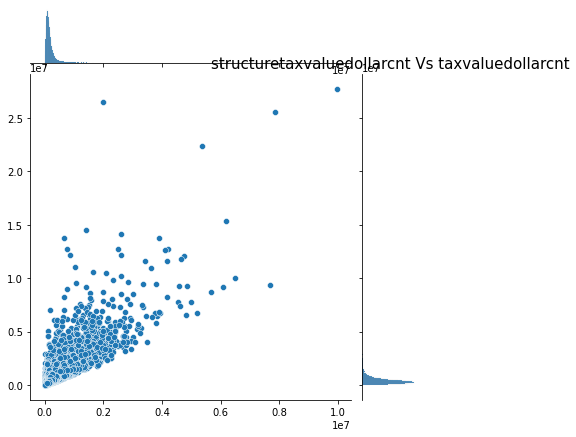

Target: taxamount
taxamount                     1.000000
taxvaluedollarcnt             0.949376
landtaxvaluedollarcnt         0.902713
structuretaxvaluedollarcnt    0.795013
Name: taxamount, dtype: float64


<Figure size 864x864 with 0 Axes>

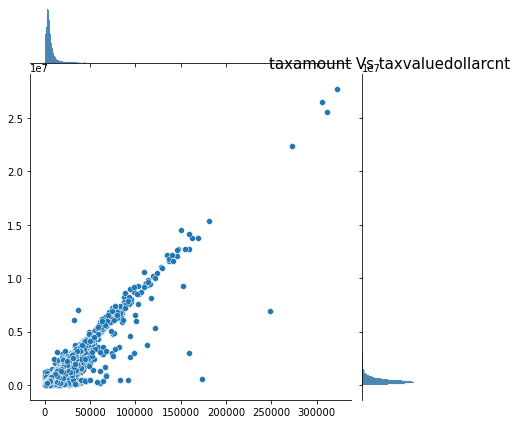

Target: landtaxvaluedollarcnt
landtaxvaluedollarcnt         1.000000
taxvaluedollarcnt             0.955336
taxamount                     0.902713
structuretaxvaluedollarcnt    0.623292
Name: landtaxvaluedollarcnt, dtype: float64


<Figure size 864x864 with 0 Axes>

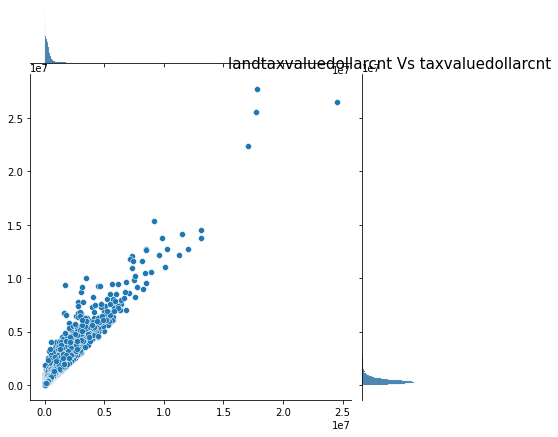

In [40]:
x =  df_tax.corr()

print('Target: structuretaxvaluedollarcnt')
print(x['structuretaxvaluedollarcnt'].sort_values(ascending = False))
plt.figure(figsize=(12,12))
sns.jointplot(x=df_tax['structuretaxvaluedollarcnt'].values, y=df_tax['taxvaluedollarcnt'].values)
plt.ylabel('taxvaluedollarcnt', fontsize=12)
plt.xlabel('structuretaxvaluedollarcnt', fontsize=12)
plt.title("structuretaxvaluedollarcnt Vs taxvaluedollarcnt", fontsize=15)
plt.show()

print('Target: taxamount')
print(x['taxamount'].sort_values(ascending = False))
plt.figure(figsize=(12,12))
sns.jointplot(x=df_tax['taxamount'].values, y=df_tax['taxvaluedollarcnt'].values)
plt.ylabel('taxvaluedollarcnt', fontsize=12)
plt.xlabel('taxamount', fontsize=12)
plt.title("taxamount Vs taxvaluedollarcnt", fontsize=15)
plt.show()

print('Target: landtaxvaluedollarcnt')
print(x['landtaxvaluedollarcnt'].sort_values(ascending = False))
plt.figure(figsize=(12,12))
sns.jointplot(x=df_tax['landtaxvaluedollarcnt'].values, y=df_tax['taxvaluedollarcnt'].values)
plt.ylabel('taxvaluedollarcnt', fontsize=12)
plt.xlabel('landtaxvaluedollarcnt', fontsize=12)
plt.title("landtaxvaluedollarcnt Vs taxvaluedollarcnt", fontsize=15)
plt.show()

In [41]:
parameters = { 'n_neighbors': [10, 20, 30, 40, 50, 100]}
fun.fillna_knn_reg(df = df_prop, base = ['taxvaluedollarcnt'], target = 'structuretaxvaluedollarcnt', tuning_params=parameters)
fun.fillna_knn_reg(df = df_prop, base = ['taxvaluedollarcnt'], target = 'taxamount', tuning_params=parameters)
fun.fillna_knn_reg(df = df_prop, base = ['taxvaluedollarcnt'], target = 'landtaxvaluedollarcnt', tuning_params=parameters)

Target:  structuretaxvaluedollarcnt
Best Score: 14557424230.4000
Best Params:  {'n_neighbors': 50}
MSE: 13725171712.0000
Done!

Target:  taxamount
Best Score: 5067913.8000
Best Params:  {'n_neighbors': 10}
MSE: 7912950.0000
Done!

Target:  landtaxvaluedollarcnt
Best Score: 17548262400.0000
Best Params:  {'n_neighbors': 10}
MSE: 14701151232.0000
Done!



In [42]:
tmp_col=df_prop.columns
tmp_list=[]

for c in tmp_col:
    if df_prop[c].isna().sum()/df_prop.shape[0]>0.0:
        tmp_list.append(c)

print("Number of features with missing values: ", len(tmp_list))
print(tmp_list)

Number of features with missing values:  4
['finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'numberofstories', 'censustractandblock']


Come si può notare restano solamente poche features con valori missing, si procede quindi:
- riempiendo 'numberofstories' con la sua moda
- rimuovendo la colonna 'censustractandblock' perché si assume che l'attributo 'rawcensustractandblock' contenga le stesse informazioni anche se in maniera meno elaborata.
- costruendo un predittore per 'calculatedfinishedsquarefeet' basato su 'bathroomcnt', 'bedroomcnt', 'structuretaxvaluedollarcnt'. Si ipotizza infatti che la dimensione totale dell'area abitabile sia dipendente da quanti bagni e camere da letto ci sono e da quante tasse sulla struttura dell'abitazione sono attribuite.
- costruendo un predittore per 'finishedfloor1squarefeet' basato sulle stesse features precedenti e sul numero di piani dell'edificio (numberofstories). Si assume che il numero di piani presenti possa essere utile per calcolare la features 'finishedfloor1squarefeet' (*Dimensioni della superficie abitativa finita al primo piano (ingresso) della casa*)

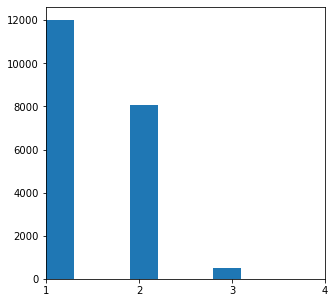

Moda:  1.0


In [43]:
plt.figure(figsize = (5,5))
x_min=df_prop['numberofstories'].min()
x_max=df_prop['numberofstories'].max()
plt.xlim([x_min, x_max])
plt.xticks(np.arange(x_min, x_max+1, 1))
df_prop['numberofstories'].hist()
plt.grid()
plt.show()

mode=float(df_prop['numberofstories'].mode())
print("Moda: ", mode)
df_prop['numberofstories'].fillna(mode, inplace=True)

In [44]:
df_prop.drop(columns='censustractandblock', inplace=True)

In [45]:
fun.fillna_knn_reg(df = df_prop, base = ['bathroomcnt', 'bedroomcnt', 'structuretaxvaluedollarcnt'], target = 'calculatedfinishedsquarefeet', tuning_params=parameters)
fun.fillna_knn_reg(df = df_prop, base = ['bathroomcnt', 'bedroomcnt', 'structuretaxvaluedollarcnt', 'numberofstories'], target = 'finishedfloor1squarefeet', tuning_params=parameters)

Target:  calculatedfinishedsquarefeet
Best Score: 172201.6437
Best Params:  {'n_neighbors': 40}
MSE: 171559.1094
Done!

Target:  finishedfloor1squarefeet
Best Score: 112725.4656
Best Params:  {'n_neighbors': 20}
MSE: 107947.8203
Done!



In [46]:
tmp_col=df_prop.columns
tmp_list=[]

for c in tmp_col:
    if df_prop[c].isna().sum()/df_prop.shape[0]>0.0:
        tmp_list.append(c)

print("Number of missing features: ", len(tmp_list))

Number of missing features:  0


In [47]:
print("Columns:")
print(df_prop.columns)
print("Shape: ", df_prop.shape)

Columns:
Index(['parcelid', 'logerror', 'transactiondate', 'airconditioningtypeid',
       'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'fips',
       'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'threequarterbathnbr', 'unitcnt', 'yearbuilt', 'numberofstories',
       'fireplaceflag', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount',
       'taxdelinquencyflag'],
      dtype='object')
Shape:  (90273, 42)


In [48]:
%store df_prop

Stored 'df_prop' (DataFrame)


<a id='custom_features'></a>
### Aggiunta di features custom potenzialmente utili

Vengono ora create ed aggiunte al dataset alcune features custom che intuitivamente potrebbero essere utili per la costruzione del modello finale e per spiegare meglio l'andamento dei dati

##### Features relative a proprietà dell'edificio

In [49]:
#Età dell'edificio al momento della vendita
df_prop['yearbuilt']=pd.to_datetime(df_prop['yearbuilt'], format='%Y')
df_prop['assessmentyear']=pd.to_datetime(df_prop['assessmentyear'], format='%Y')
df_prop['Life-until-selling']=(df_prop['transactiondate']-df_prop['yearbuilt']).dt.days

#Rapporto tra structure value e land area 
df_prop['N-ValueProp'] = df_prop['structuretaxvaluedollarcnt']/df_prop['landtaxvaluedollarcnt']

#Porzione di area vivibile
df_prop['N-LivingAreaProp'] = df_prop['calculatedfinishedsquarefeet']/df_prop['lotsizesquarefeet']

#Quantità di spazio extra
df_prop['N-ExtraSpace'] = df_prop['lotsizesquarefeet'] - df_prop['calculatedfinishedsquarefeet'] 

#Features che indica se la proprietà ha garage, piscina, o ibromassaggio e AC
df_prop['N-GarPoolAC'] = ((df_prop['garagecarcnt']>0) & (df_prop['hashottuborspa']>0) & (df_prop['airconditioningtypeid']!=5))*1
df_prop['N-GarPoolAC']=df_prop['N-GarPoolAC'].astype(bool)

In [50]:
#Rapporto tasse sulla casa su tasse totali per assesment year
df_prop['N-ValueRatio'] = df_prop['taxvaluedollarcnt']/df_prop['taxamount']

#Total Tax Score
df_prop['N-TaxScore'] = df_prop['taxvaluedollarcnt']*df_prop['taxamount']

##### Features relative alla posizione

In [51]:
#Numero di proprietà per zip code
zip_count = df_prop['regionidzip'].value_counts().to_dict()
df_prop['N-zip_count'] = df_prop['regionidzip'].map(zip_count)

#Numero di proprietà per città
city_count = df_prop['regionidcity'].value_counts().to_dict()
df_prop['N-city_count'] = df_prop['regionidcity'].map(city_count)

#Numero di proprietà per per paese
region_count = df_prop['regionidcounty'].value_counts().to_dict()
df_prop['N-county_count'] = df_prop['regionidcounty'].map(region_count)

##### Features che sono la semplificazione di altre features

In [52]:
#Indicatore se AC è presente o no
df_prop['N-ACInd'] = (df_prop['airconditioningtypeid']!=5)*1
df_prop['N-ACInd']=df_prop['N-ACInd'].astype(bool)

#Indicatore se riscaldamento è presente o no
df_prop['N-HeatInd'] = (df_prop['heatingorsystemtypeid']!=13)*1
df_prop['N-HeatInd']=df_prop['N-HeatInd'].astype(bool)

#Tipo di destinazione d'uso del terreno per il quale è suddiviso in zone l'immobile - prima erano 25 categorie, ora vengono compresse a 4
df_prop['N-PropType'] = df_prop['propertylandusetypeid'].replace({31 : "Mixed", 46 : "Other", 47 : "Mixed", 246 : "Mixed", 247 : "Mixed", 248 : "Mixed", 260 : "Home", 261 : "Home", 262 : "Home", 263 : "Home", 264 : "Home", 265 : "Home", 266 : "Home", 267 : "Home", 268 : "Home", 269 : "Not Built", 270 : "Home", 271 : "Home", 273 : "Home", 274 : "Other", 275 : "Home", 276 : "Home", 279 : "Home", 290 : "Not Built", 291 : "Not Built" })
df_prop.drop(columns='propertylandusetypeid', inplace=True)

##### Features custom relative a 'structuretaxvaluedollarcnt' perché viene considerata una specifica importante

In [53]:
#Media di structuretaxvaluedollarcnt per città
group = df_prop.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
df_prop['N-Avg-structuretaxvaluedollarcnt'] = df_prop['regionidcity'].map(group) #assegna 'regionidcity' alla media calcolata sopra e messa in un dizionario con chiave 'regionidcity'

#Discostamento del valore dalla media
df_prop['N-Dev-structuretaxvaluedollarcnt'] = abs((df_prop['structuretaxvaluedollarcnt'] - df_prop['N-Avg-structuretaxvaluedollarcnt']))/df_prop['N-Avg-structuretaxvaluedollarcnt']

In [54]:
#Nel caso siano presenti valori "Infinito" nel dataset derivanti da divisioni per zero questi vengono posti a 0 in quanto semanticamente corretto
df_prop.replace([np.inf, -np.inf], 0, inplace=True)

In [55]:
#Converione dei tipi delle nuove features da float64 a float32 per ridurre lo spazio occupato in memoria
df_prop[df_prop.select_dtypes(np.float64).columns] = df_prop.select_dtypes(np.float64).astype(np.float32)

In [56]:
df_prop.info()
print("Shape: ", df_prop.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90273 entries, 0 to 90274
Data columns (total 56 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   parcelid                          90273 non-null  int64         
 1   logerror                          90273 non-null  float32       
 2   transactiondate                   90273 non-null  datetime64[ns]
 3   airconditioningtypeid             90273 non-null  float32       
 4   bathroomcnt                       90273 non-null  float32       
 5   bedroomcnt                        90273 non-null  float32       
 6   buildingqualitytypeid             90273 non-null  float32       
 7   finishedfloor1squarefeet          90273 non-null  float32       
 8   calculatedfinishedsquarefeet      90273 non-null  float32       
 9   fips                              90273 non-null  float32       
 10  fireplacecnt                      90273 non-nu

In [57]:
%store df_prop

Stored 'df_prop' (DataFrame)


<a id='features_selection'></a>
### Features importance, features selection e preparazione del dataset finale


Arrivati a questo punto il dataset non presenta più valori mancanti e intuitivamente sono stati risolti i problemi di multicollinearità tra le features date in input, evidenziati nelle analisi precedenti. Può essere quindi svolto il processo di features selection in modo da costruire modelli previsionali ancora più accurati

In [58]:
cat_var_names=set(['airconditioningtypeid', 'heatingorsystemtypeid', 'propertycountylandusecode', 'N-PropType',
       'propertyzoningdesc', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'fips', 'rawcensustractandblock'])

for c in cat_var_names:
    print(c, len(df_prop[c].unique()) )

regionidcity 177
regionidzip 388
regionidneighborhood 494
airconditioningtypeid 6
N-PropType 3
fips 3
regionidcounty 3
heatingorsystemtypeid 12
propertyzoningdesc 1996
rawcensustractandblock 470
propertycountylandusecode 77


Si decide però di rimuovere alcune delle variabili categoriali con molti elementi distinti (nello specifico 'propertyzoningdesc', 'propertycountylandusecode', 'regionidneighborhood', 'regionidzip', 'regionidcity', 'rawcensustractandblock') in modo da non aumentare esponenzialmente la dimensione della matrice dopo il processo di OneHotEncoding (possibile anche problema di curse of dimensionality) ed innalzare il tempo richiesto per il training e il testing dei modelli.<br>
Si fa presente che questo processo di encoding è necessario per la corretta gestione di features categriali, altrimenti queste verrebbero interpretate in modo numerico o ordinale 

In [59]:
removed_cat=set(['propertyzoningdesc', 'propertycountylandusecode' , 'regionidneighborhood', 'regionidzip', 'regionidcity', 'rawcensustractandblock'])
one_hot_colmuns=list(cat_var_names.difference(removed_cat))


one_hot_enc=OneHotEncoder(sparse=False)
one_hot_enc.fit(df_prop[one_hot_colmuns])
one_hot_tranform_name=one_hot_enc.get_feature_names(one_hot_colmuns)

one_hot_df=pd.DataFrame(one_hot_enc.transform(df_prop[one_hot_colmuns]), columns=one_hot_tranform_name)

df_prop_drop_cat=df_prop.drop(columns=list(cat_var_names))
df_prop_final=pd.concat([df_prop_drop_cat.reset_index(), one_hot_df.reset_index()], axis=1)
df_prop_final.drop(columns=['index'], inplace=True)


#Convert date to integer
df_prop_final['yearbuilt']=df_prop_final['yearbuilt'].dt.year
df_prop_final['assessmentyear']=df_prop_final['assessmentyear'].dt.year

In [60]:
print("Final shape: ", df_prop_final.shape)

Final shape:  (90273, 72)


In [61]:
X=df_prop_final.drop(columns=['parcelid', 'logerror', 'transactiondate'])
y=df_prop_final['logerror'].values

X e y conterranno rispettivamente:
- le features da usare per la costruzione del modello
- i valori reali da utilizzare per il task di supervised learning

*Si fa notare che le variabili contengono solo dati di tipo float (o convertibili in float) perché unici tipi accettati dagli algoritmi di ML utilizzati*

Si procede nella sezione sottostante al tuning del parametro "n_estimators" per la costruzione di un modello sfruttante gradient boosting che una volta allenato verrà utilizzato per selezionare le features ritenute di maggior impatto dall'algoritmo<br>
Si fa notare inoltre che è stata scelta la libreria XGBoost per la sua elevata efficienza ed accuratezza

In [62]:
tuning_params={'n_estimators': [i for i in range(1, 26, 1)]}

X_train_80, X_test, y_train_80, y_test = train_test_split(X, y, 
                                                         test_size=0.20, random_state=42)

xgb_model=xgb.XGBRegressor()
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=tuning_params,
                         cv=5, scoring='neg_mean_squared_error', 
                         verbose = 0, n_jobs=-1)

print ("Tuning XGBoost hyperparameters:")
xgb_grid.fit(X_train_80, y_train_80)
print ("Best Score: {:.4f}".format(-xgb_grid.best_score_) )
print ("Best Params: ", xgb_grid.best_params_)

test_mse= mean_squared_error(y_true = y_test, y_pred = xgb_grid.predict(X_test) )
print ("MSE: {:.4f}".format(test_mse) )

Tuning XGBoost hyperparameters:
Best Score: 0.0262
Best Params:  {'n_estimators': 13}
MSE: 0.0258


In [63]:
%store xgb_grid

Stored 'xgb_grid' (GridSearchCV)


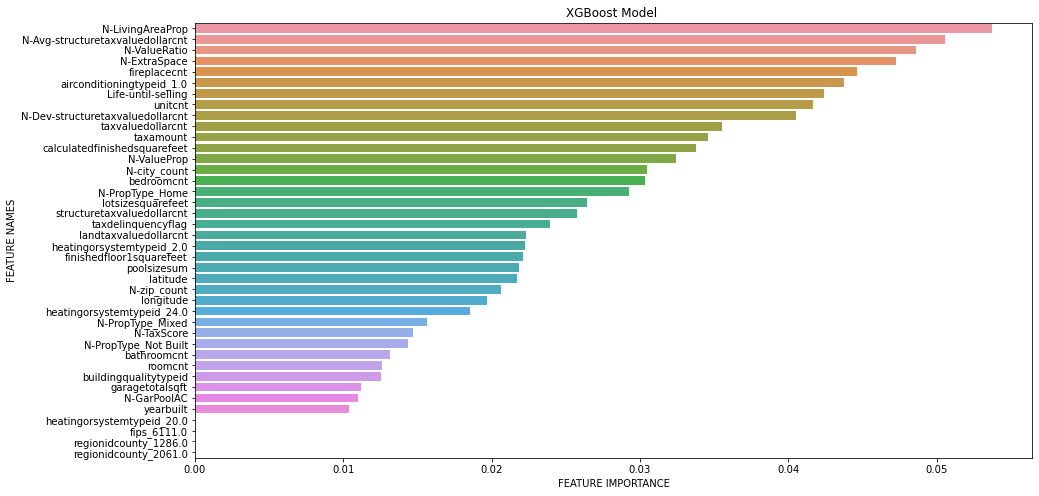

In [64]:
fun.plot_feature_importance(xgb_grid.best_estimator_.feature_importances_, X.columns, 'XGBoost Model ', limit=40)

*Si nota dal grafico riguardante la features importance che molte delle variabili custom aggiunte precedentemente hanno un peso rilevante nella costruzione del modello*

Viene ora scelto mediante il successivo metodo di feature ranking con recursive feature elimination usante cross-validation sets il presunto miglior sottinsieme di n features in modo da ridurre, come anticipato, la dimensionalità del dataframe ed i conseguenti problemi di multicollinearità e curse of dimentionality per ottimizzare maggiormente le previsioni.<br>
Si è deciso di impostare un numero minimo di 10 features in modo che nel modello finale non rimangano troppe poche variabili che di conseguenza non riuscirebbero a spiegare in modo sufficientemente accurato i dati.

In [65]:
selector = RFECV(xgb_grid.best_estimator_, 
                 step=1,
                 cv=5,
                 scoring='neg_mean_squared_error',
                 min_features_to_select=10,  
                 n_jobs=-1
                )
selector.fit(X,y)
selector.n_features_

12

Le features selezionate dall'algoritmo sono quindi 12, nello specifico:

In [66]:
list_important_features=[x[0] for x in list(zip(X.columns, selector.support_)) if x[1]]
print(list_important_features)

['finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag', 'Life-until-selling', 'N-ValueRatio', 'N-city_count', 'N-Avg-structuretaxvaluedollarcnt', 'N-Dev-structuretaxvaluedollarcnt']


Viene creato e salvato offline il dataset contenete le features selezionate in modo che possa poi essere usato per la costruzione dei due modelli finali o per eventuali analisi future

In [67]:
selected_important_X=X[list_important_features]
selected_important_X.shape

(90273, 12)

In [68]:
selected_important_X.to_parquet(input_folder+"final_df_2016.parquet")

<a id='mod_1'></a>
### Corstruzione del modello sfruttante Random Forest e tuning dei suoi parametri

In questa fase si è deciso di realizzare in modo più sofisticato il tuning degli parametri.
Nello specifico il metodo con cross validation sets cercherà la migliore combinazione di "n_estimators", "max_leaf_nodes" e "min_samples_leaf", 3 degli iperparametri principali per la costruzione del regressore sfruttante il metodo di ensembling Random Forest

In [69]:
X_train_80, X_test, y_train_80, y_test = train_test_split(selected_important_X, y, 
                                                         test_size=0.20, random_state=42)

In [72]:
tuning_params={'n_estimators': [i for i in range(10, 81, 10)],
                'max_leaf_nodes': [10, 30, 50, 100, 200], #Grow trees with max_leaf_nodes in best-first fashion
                'min_samples_leaf': [i for i in range(1, 5, 1)]} #The minimum number of samples required to be at a leaf node.

rf=RandomForestRegressor()
rf_model = GridSearchCV(estimator=rf, param_grid=tuning_params,
                         cv=5, scoring='neg_mean_squared_error', 
                         verbose = 0, n_jobs=-1)

print ("Tuning Random Forest hyperparameters:")
rf_model.fit(X_train_80, y_train_80)
print ("Best Score: {:.4f}".format(-rf_model.best_score_) )
print ("Best Params: ", rf_model.best_params_)

test_mse= mean_squared_error(y_true = y_test, y_pred = rf_model.predict(X_test) )
print ("MSE: {:.4f}".format(test_mse) )

Tuning Random Forest hyperparameters:
Best Score: 0.0258
Best Params:  {'max_leaf_nodes': 100, 'min_samples_leaf': 4, 'n_estimators': 80}
MSE: 0.0254


Si ritiene che i valori di Mean Squared Error ottenuti, in particolare nel testing set, siano sufficientemente bassi e che di conseguenza il modello usante Random Forest sia abbastanza accurato. Inoltre utilizzando i cross validation sets si è limitata la possibilità di overfitting del predittore

In [73]:
%store rf_model

Stored 'rf_model' (GridSearchCV)


Error/Bias/Variance at the last iteration: [0.02551581 0.02538055 0.00013526]


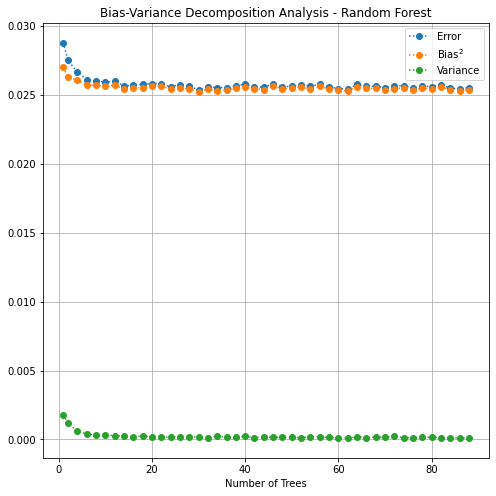

In [74]:
N_TESTS = 2
step=2
offset=10

stats = np.array([])
n_trees = [1 if i==0 else i for i in range(0, rf_model.best_params_['n_estimators']+offset, step)]

for l in n_trees:
    y_preds = np.array([])

    for i in range(N_TESTS):
        Xs, ys = resample(X_train_80, y_train_80, n_samples=int(0.67*len(y_train_80)))
        
        rf = RandomForestRegressor(n_estimators=l, max_leaf_nodes=rf_model.best_params_[
                                   'max_leaf_nodes'], min_samples_leaf=rf_model.best_params_['min_samples_leaf'], n_jobs=-1)
        rf.fit(Xs, ys)

        y_pred = rf.predict(X_test)
        y_preds = np.column_stack(
            [y_preds, y_pred]) if y_preds.size else y_pred

    dt_bias = (y_test-np.mean(y_preds, axis=1))**2
    dt_variance = np.var(y_preds, axis=1)
    dt_error = (y_preds - y_test.reshape(-1, 1))**2.0

    run_stats = np.array([dt_error.mean(), dt_bias.mean(), dt_variance.mean()])

    stats = np.column_stack([stats, run_stats]) if stats.size else run_stats


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Bias-Variance Decomposition Analysis - Random Forest")
ax.plot(n_trees, stats[0, :], 'o:', label='Error')
ax.plot(n_trees, stats[1, :], 'o:', label='Bias$^2$')
ax.plot(n_trees, stats[2, :], 'o:', label='Variance')
ax.set_xlabel('Number of Trees')
ax.grid()
ax.legend()

print("Error/Bias/Variance at the last iteration:", stats[:, -1])

Come si può notare dal grafico *numero alberi - errore totale*, l'errore diminuisce (e lo score migliora) all'aumetare del numero di stimatori utilizzati. In particolare si evince, come da intuizione teorica, che essendo il predittore basato su foresta di alberi ogniuno di questi per definizione si cerca sia fully grown, quindi con bassa distorsione e alta varianza, e che quest'ultima varrà poi ridotta con l'ensembing. In questo specifico caso è evidenziato come si riesca a ridurre la varianza in modo significativo già usando solamente 4 stimatori.<br>
Si ricorda poi che la formula di decomposizione dell'errore totale è:
$$
Error(M) = Bias^2 + Variance + Noise
$$

<a id='mod_2'></a>
### Corstruzione del modello sfruttante Gradient Boosting e tuning dei suoi parametri

Anche per la costruzione di questo modello si è deciso di realizzare più sofisticatamente il tuning degli parametri.
Nello specifico il metodo con cross validation sets cercherà la migliore combinazione di "n_estimators", "max_leaves" e "learning_rate", 3 degli iperparametri principali per la costruzione del regressore sfruttante il metodo Gradient Boosting

In [75]:
X_train_80, X_test, y_train_80, y_test = train_test_split(selected_important_X, y, 
                                                         test_size=0.20, random_state=42)

In [76]:
tuning_params={'n_estimators': [i for i in range(10, 101, 10)],
                'max_leaves': [2, 5, 10, 50, 100, 200], #Maximum number of leaves; 0 indicates no limit
                'learning_rate': [0.1, 0.2, 0.3, 0.4]} #Boosting learning rate (xgb’s “eta”). 
                                                       #Step size shrinkage used in update to prevents overfitting. The value must be between 0 and 1. Default is 0.3.

xgb_m=xgb.XGBRegressor()
xgb_model = GridSearchCV(estimator=xgb_m, param_grid=tuning_params,
                         cv=5, scoring='neg_mean_squared_error', 
                         verbose = 0, n_jobs=-1)

print ("Tuning XGBoost hyperparameters:")
xgb_model.fit(X_train_80, y_train_80)
print ("Best Score: {:.4f}".format(-xgb_model.best_score_))
print ("Best Params: ", xgb_model.best_params_)

test_mse= mean_squared_error(y_true = y_test, y_pred = xgb_model.predict(X_test) )
print ("MSE: {:.4f}".format(test_mse))

Tuning XGBoost hyperparameters:
Best Score: 0.0259
Best Params:  {'learning_rate': 0.1, 'max_leaves': 2, 'n_estimators': 50}
MSE: 0.0257


Anche in questo caso si ritiene che i valori di Mean Squared Error ottenuti, in particolare nel testing set, siano sufficientemente bassi e che di conseguenza il modello basato su Gradient Boosting sia abbastanza accurato. Inoltre utilizzando i cross validation sets si è limitata la possibilità di overfitting nel regressore

In [77]:
%store xgb_model

Stored 'xgb_model' (GridSearchCV)


Error/Bias/Variance at the last iteration: [0.02586752 0.02552025 0.00034727]


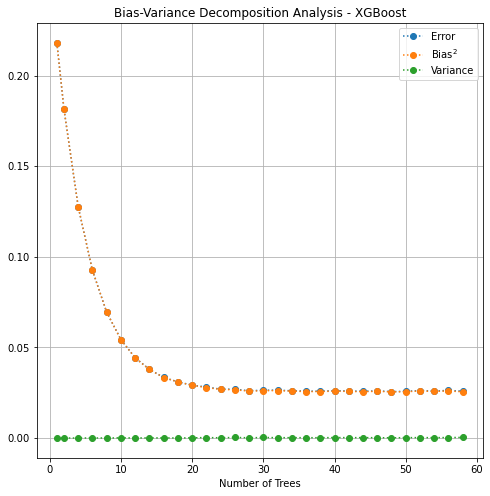

In [78]:
N_TESTS = 2
step=2
offset=10

stats = np.array([])
n_trees = [1 if i==0 else i for i in range(0, xgb_model.best_params_['n_estimators']+offset, step)]

for l in n_trees:
    y_preds = np.array([])

    for i in range(N_TESTS):
        Xs, ys = resample(X_train_80, y_train_80, n_samples=int(0.67*len(y_train_80)))
       
        xgb_m = xgb.XGBRegressor(n_estimators=l, learning_rate=xgb_model.best_params_[
                                   'learning_rate'], max_leaves=xgb_model.best_params_['max_leaves'], n_jobs=-1)
        xgb_m.fit(Xs, ys)

        y_pred = xgb_m.predict(X_test)
        y_preds = np.column_stack(
            [y_preds, y_pred]) if y_preds.size else y_pred

    dt_bias = (y_test-np.mean(y_preds, axis=1))**2
    dt_variance = np.var(y_preds, axis=1)
    dt_error = (y_preds - y_test.reshape(-1, 1))**2.0

    run_stats = np.array([dt_error.mean(), dt_bias.mean(), dt_variance.mean()])

    stats = np.column_stack([stats, run_stats]) if stats.size else run_stats


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Bias-Variance Decomposition Analysis - XGBoost")
ax.plot(n_trees, stats[0, :], 'o:', label='Error')
ax.plot(n_trees, stats[1, :], 'o:', label='Bias$^2$')
ax.plot(n_trees, stats[2, :], 'o:', label='Variance')
ax.set_xlabel('Number of Trees')
ax.grid()
ax.legend()

print("Error/Bias/Variance at the last iteration:", stats[:, -1])

Come si può notare dal grafico, anche in questo caso l'errore dimiuisce (e lo score migliora) all'aumetare del numero di stimatori utilizzato. In particolare si evince, come da intuizione teorica, che essendo il predittore basato su boosting di alberi, ogniuno di questi per definizione si cerca sia di dimensioni ridotte, quindi con bassa varianza ma alta distorsione, e che quest'ultima varrà varrà poi ridotta con l'ensembing. 
In questo specifico caso la decomposizione mostra una varianza quasi nulla ed un errore che descresce esponenzialmente al diminuire della distorzione, che si riesce inoltre a ridurre in modo significativo già usando solamente 10 stimatori.

<a id='comparison_and_analisys'></a>
### Comparazione e analisi dei modelli

Ultimata la costruzione dei modelli statistici finali si porcede ora ad analizzarne più approfonditamente il comportamento, in particolare fecendo un focus su alcuni degli edifici dove il logerror dato è il peggiore ed altri dove è il migliore.

Vengono quindi estratti gli edifici con log error compreso tra il valore più estremo e il valore più estremo meno 1 (worst items) e dieci tra le costruzioni dove il log error è zero (best items)

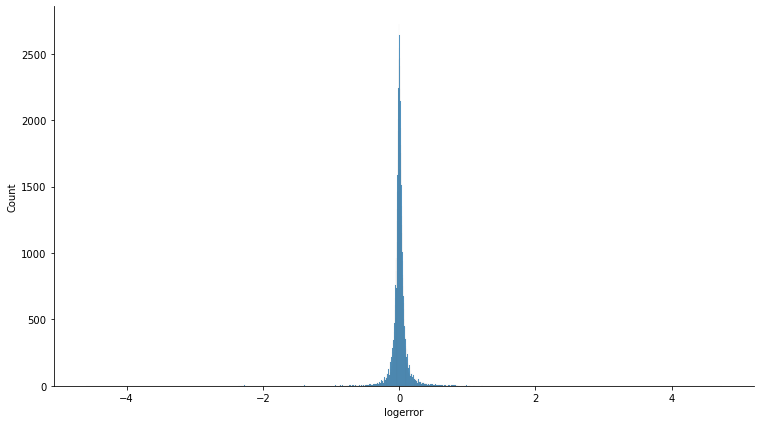

In [95]:
sns.displot(df_prop_final, x="logerror", height=6, aspect=16/9);

La variabile 'logerror' segue una distribuzione normale

In [96]:
offset=1
max_error_pos=df_prop_final['logerror'].max()-offset
max_error_neg=df_prop_final['logerror'].min()+offset

worst_items=pd.concat([df_prop_final[df_prop_final['logerror']>=max_error_pos], df_prop_final[df_prop_final['logerror']<=max_error_neg]])
best_items=df_prop_final[df_prop_final['logerror']==0].head(10)

In [97]:
worst_items_X=selected_important_X.iloc[worst_items.index]
worst_items_X

,finishedfloor1squarefeet,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,taxvaluedollarcnt,taxamount,taxdelinquencyflag,Life-until-selling,N-ValueRatio,N-city_count,N-Avg-structuretaxvaluedollarcnt,N-Dev-structuretaxvaluedollarcnt
7318,3012.850098,2640.0,46196.0,713986.0,2289855.0,28355.099609,False,4050,80.756371,20635,190930.046875,2.739516
8612,2042.750000,1795.0,31636.0,495911.0,1127070.0,13866.839844,False,3692,81.278069,20635,190930.046875,1.597344
22475,2721.199951,3179.0,22207.0,344385.0,1064036.0,12303.690430,False,19818,86.481041,776,228180.687500,0.509264
22476,4634.200195,3142.0,21816.0,2256798.0,2488740.0,28388.460938,False,19818,87.667313,776,228180.687500,8.890399
6416,1253.849976,985.0,5654.0,57838.0,289210.0,3821.810059,False,23404,75.673569,294,95555.125000,0.394716
69226,943.000000,1843.0,5365.0,221718.0,367233.0,4274.120117,False,6445,85.920143,1265,195516.031250,0.134014
88786,1578.800049,1417.0,6344.0,133772.0,668863.0,8238.679688,False,28098,81.185699,20635,190930.046875,0.299366


In [98]:
best_items_X=selected_important_X.iloc[best_items.index]
best_items_X

,finishedfloor1squarefeet,calculatedfinishedsquarefeet,lotsizesquarefeet,structuretaxvaluedollarcnt,taxvaluedollarcnt,taxamount,taxdelinquencyflag,Life-until-selling,N-ValueRatio,N-city_count,N-Avg-structuretaxvaluedollarcnt,N-Dev-structuretaxvaluedollarcnt
64,1356.750000,1344.0,9800.0,133631.0,418161.0,4727.779785,False,13517,88.447647,1859,131900.109375,0.013123
143,1214.000000,1214.0,6660.0,34946.0,55976.0,5453.899902,False,21187,10.263481,1040,137598.609375,0.746029
223,1099.449951,1289.0,5457.0,135760.0,496934.0,6527.640137,False,23379,76.127663,654,100058.273438,0.356809
339,1591.250000,1601.0,6146.0,183436.0,245366.0,4347.359863,False,25206,56.440231,588,84266.335938,1.176860
655,3112.000000,3112.0,41230.0,1164559.0,1773180.0,19705.199219,False,20093,89.985390,251,246775.453125,3.719104
694,922.799988,1036.0,8116.0,24863.0,36666.0,3802.540039,False,22285,9.642502,757,116343.429688,0.786296
826,1353.099976,930.0,310302.0,111585.0,204505.0,2590.560059,False,10232,78.942390,757,116343.429688,0.040900
833,1808.800049,1374.0,5000.0,135990.0,458000.0,5073.439941,False,9501,90.274055,1859,131900.109375,0.031007
870,980.549988,792.0,1901.0,127168.0,579664.0,7093.660156,False,32147,81.715782,20635,190930.046875,0.333955
1123,1622.449951,2062.0,8948.0,178500.0,222000.0,3355.659912,False,18633,66.156883,2038,128246.671875,0.391849


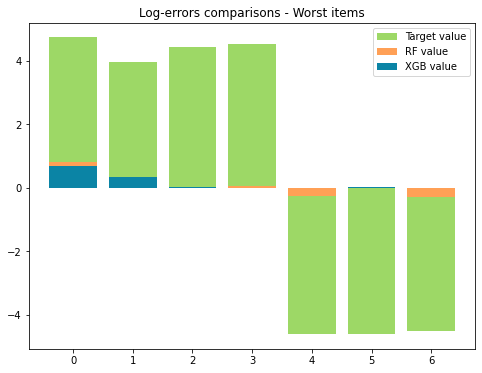

In [137]:
plt.figure(figsize=(8, 6))
plt.bar(range(len(worst_items)), worst_items['logerror'], color=['#9dd866'], label = "Target value")
plt.bar(range(len(worst_items)), rf_model.predict(worst_items_X), color=['#ffa056'], label = "RF value")
plt.bar(range(len(worst_items)), xgb_model.predict(worst_items_X), color=['#0b84a5'], label = "XGB value")
plt.legend()
plt.title("Log-errors comparisons - Worst items");

Dal bar chart relativo alle previsioni su item problematici si può notare che le stime dei due modelli finali creati sono molto distanti dal valore target calcolato dallo stimatore Zestimate. Probabilmente questo è dovuto alla presenza di molti valori missing o outliers, trattati con tecniche di analisi, recupero e correzione differenti da quelle usate dal team di Zestimate.
A priori però si ipotizza che gli item con logerror in valore assoluto elevato possano presentare anomalie o valori non standard per alcune features, in quanto proprio lo stimatore della competizione restituisce dei valori predetti abbastanza distanti dal log(SalePrice) reale.

Per verificare queste ipotesi si pensa sia necessario contattare degli esperti in ambito Data Science, il team di Zestimate e dei tecnici immobiliari.

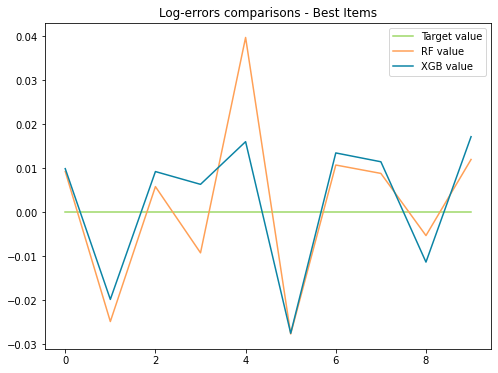

In [100]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(best_items)), best_items['logerror'], color='#9dd866', label = "Target value", )
plt.plot(range(len(best_items)), rf_model.predict(best_items_X), color='#ffa056', label = "RF value")
plt.plot(range(len(best_items)), xgb_model.predict(best_items_X), color='#0b84a5', label = "XGB value")
plt.legend()
plt.title("Log-errors comparisons - Best Items");

Nel line chart inerente alle previsioni su item il cui log error è nullo invece anche i due modelli creati restituiscono valori soddisfacienti: infatti, il discostamento rispetto al valore target di Zestimate è nell'ordine dei centesini

In generale, anche nei grafici relativi a best items e worst items, non si notano grosse differenze in termini di accuratezza tra il modello con Random Forest e quello con Gradient Boosting, anche se il valore di MSE ottenuto nel testing set del primo modello e leggermente inferiore rispetto a quello restituito dal secondo.

<a id='final'></a>
### Considerazioni finali

Vengono quindi brevemente ricapitolati i vari passaggi svolti:
- Analisi dei dataset, features engineering e gestione dei missing value
- Features selection e costruzione dei modelli
- Analisi e comparazione dei modelli ottenuti

Concludendo, grazie a questo task si sono potuto testare su un dataset reale, esteso e complesso, le performance di alcuni metodi di Machine Learning come Random Forest e Gradient Boosting, entrambi sfruttanti alberi di decisione ma utilizzanti intuizioni diverse.<br>
Tuttavia, come anticipato in precedenza, non si dispone di sufficienti elementi per preferire un modello rispetto all'altro in quanto entrambi ritornano previsioni accurate ed in modo efficiente e il discostamento nel valore della metrica di valutazione per il testing set è molto bassa.
Generalmente, i predittori che utilizzano la tecnica Gradient Boosting performano meglio di quelli che sfruttano Random Forest per definizione in quanto hanno come obiettivo la minimizzazione di una funzione di perdita e la caratteristica di costruire additivamente i vari alberi, anche se sono più proni all'overfitting.<br>
Probabilmente, con una conoscenza più approfondita dei dati, del loro significato, del loro andamento reale e con l'aggiunta di informazioni esterne al dataset è possibile arrivare ad ottenere risultati ancora più precisi ed alla costruzione del modello di regressione ottimo.

##### *Tabella riassuntiva contenente i dati delle valutazioni*
| Set type | Model | MSE Score |
| --- | --- | --- |
| Validation Sets | Random Forest | 0.0258 |
| Validation Sets | Gradient Boosting | 0.0259 |
| Testing Set | Random Forest | 0.0254 |
| Testing Set | Gradient Boosting | 0.0257 |